In [83]:
import pandas as pd

In [84]:
df = pd.read_csv('timeseries.csv')  

In [85]:
# Select only numeric columns for calculating the mean
numeric_columns = df.select_dtypes(include=['number']).columns

# Fill missing values only for numeric columns with their respective mean
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())


In [86]:
# Check column names in the DataFrame
print(df.columns)

Index(['time', 'P', 'Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int'], dtype='object')


In [87]:
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')

df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['weekday'] = df['time'].dt.weekday  # Monday=0, Sunday=6

print(df[['time', 'hour', 'day', 'month', 'year', 'weekday']].head())


                 time  hour  day  month  year  weekday
0 2014-12-31 23:46:00    23   31     12  2014        2
1 2015-01-01 00:46:00     0    1      1  2015        3
2 2015-01-01 01:46:00     1    1      1  2015        3
3 2015-01-01 02:46:00     2    1      1  2015        3
4 2015-01-01 03:46:00     3    1      1  2015        3


In [88]:
# Create lag features for 'P' (power output)
df['P_lag1'] = df['P'].shift(1)  # P(t-1)
df['P_lag2'] = df['P'].shift(2)  # P(t-2)
df['P_lag3'] = df['P'].shift(3)  # P(t-3)

df.dropna(inplace=True)


In [89]:
# Create a rolling mean for 'P'
df['P_rolling_mean'] = df['P'].rolling(window=6).mean()

# Drop rows with NaN values caused by rolling
df.dropna(inplace=True)


In [90]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select the features to scale (exclude 'P' if it's your target)
features_to_scale = ['Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int', 'hour', 'day', 'month', 'year', 'weekday']

# Option 1: StandardScaler (Z-score normalization)
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Option 2: MinMaxScaler (scale between 0 and 1)
# scaler = MinMaxScaler()
# df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


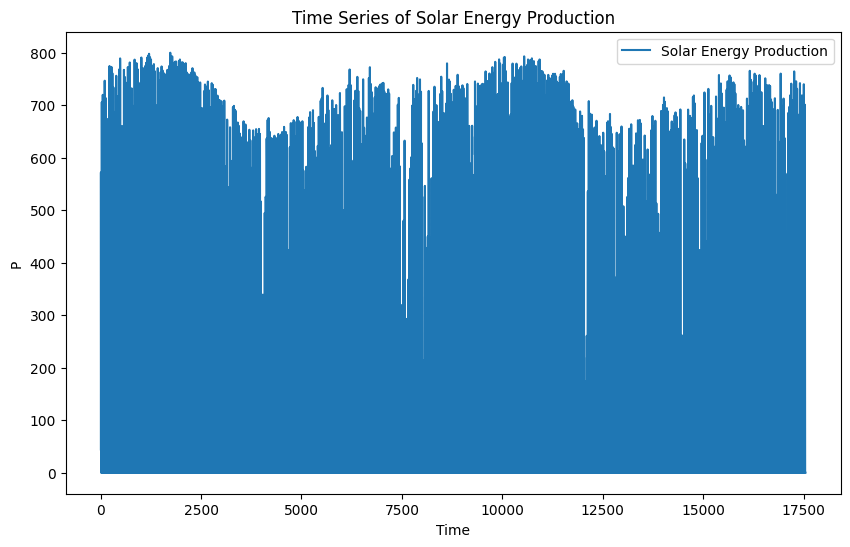

In [101]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['P'], label='Solar Energy Production')
plt.xlabel('Time')
plt.ylabel('P')
plt.title('Time Series of Solar Energy Production')
plt.legend()
plt.show()

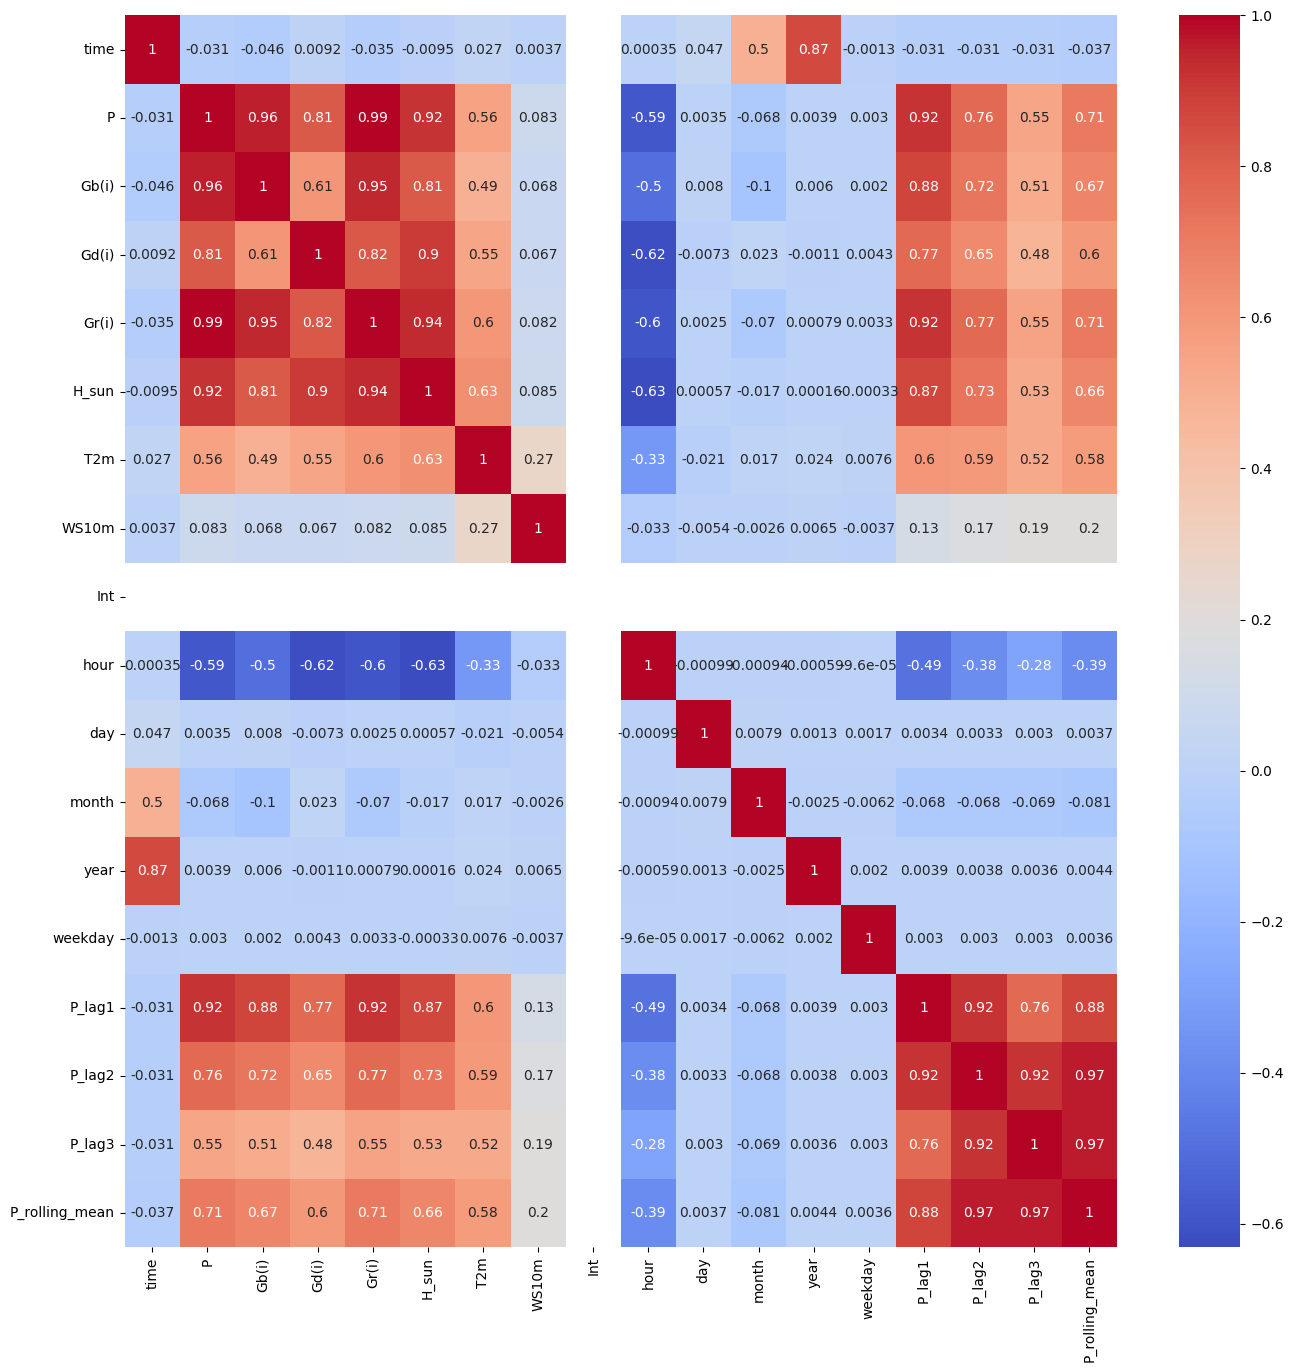

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [92]:
df.columns

Index(['time', 'P', 'Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int',
       'hour', 'day', 'month', 'year', 'weekday', 'P_lag1', 'P_lag2', 'P_lag3',
       'P_rolling_mean'],
      dtype='object')

Mean Squared Error: 39.83856267300686
R^2 Score: 0.9993609884506567


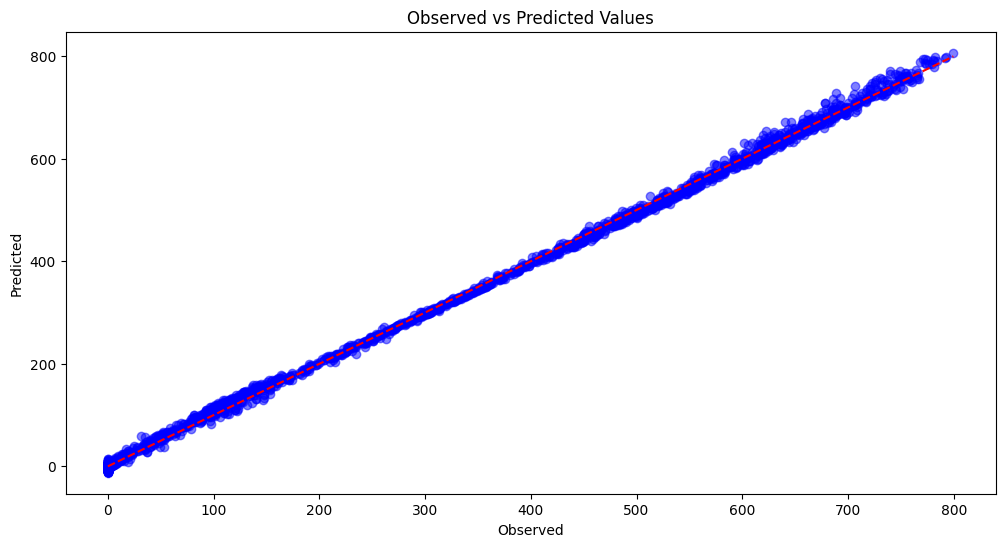

In [94]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Example DataFrame setup
# data = pd.read_csv('your_data.csv', parse_dates=['time'], index_col='time')

# Define features and target variable
features = ['Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int','hour', 'day', 'month', 'year', 'weekday', 'P_lag1', 'P_lag2', 'P_lag3', 'P_rolling_mean']
X = df[features]
y = df['P']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the observed vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted Values')
plt.show()

#rconfusion matrix

In [100]:
import pandas as pd

# Assuming 'df' is your DataFrame and is already loaded

# Step 1: Check DataFrame columns
print(df.columns)

# Ensure the 'time' column is in datetime format
if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
else:
    print("Column 'time' not found in DataFrame.")

# Extract date from the datetime column for filtering
df['date'] = df['time'].dt.date

# Step 2: Extract one day's worth of data
specific_date = '2015-09-20'  # Replace with the desired date in 'YYYY-MM-DD' format
one_day_data = df[df['date'] == pd.to_datetime(specific_date).date()]

# Step 3: Prepare the input data for prediction
one_day_data = one_day_data.sort_values(by='time')
X_input = one_day_data[features]

# Step 4: Make predictions for the next day
next_day_predictions = model.predict(X_input)

# Create a DataFrame for the next day's predictions
next_day_start = pd.to_datetime(specific_date) + pd.Timedelta(days=1)  # Start from the next day
next_day_index = pd.date_range(start=next_day_start, periods=len(next_day_predictions), freq='H')
predicted_df = pd.DataFrame(next_day_predictions, index=next_day_index, columns=['Predicted_P'])

# Display the predictions
print(predicted_df)


Index(['time', 'P', 'Gb(i)', 'Gd(i)', 'Gr(i)', 'H_sun', 'T2m', 'WS10m', 'Int',
       'hour', 'day', 'month', 'year', 'weekday', 'P_lag1', 'P_lag2', 'P_lag3',
       'P_rolling_mean', 'date'],
      dtype='object')
                     Predicted_P
2015-09-21 00:00:00     0.369613
2015-09-21 01:00:00    74.775034
2015-09-21 02:00:00   294.282924
2015-09-21 03:00:00   513.298278
2015-09-21 04:00:00   479.419386
2015-09-21 05:00:00   533.551031
2015-09-21 06:00:00   449.961151
2015-09-21 07:00:00   559.056229
2015-09-21 08:00:00   468.653504
2015-09-21 09:00:00   390.980125
2015-09-21 10:00:00   218.219133
2015-09-21 11:00:00    65.728423
2015-09-21 12:00:00    -8.210263
2015-09-21 13:00:00    -3.761095
2015-09-21 14:00:00     0.025241
2015-09-21 15:00:00     0.236874
2015-09-21 16:00:00    -1.891984
2015-09-21 17:00:00    -2.981757
2015-09-21 18:00:00    -2.033469
2015-09-21 19:00:00    -1.139404
2015-09-21 20:00:00    -1.110182
2015-09-21 21:00:00    -1.356803
2015-09-21 22:00:00    -1.

/var/folders/r9/ld6l7sg96rn5bb8nz9j2dx580000gn/T/ipykernel_35531/65756399.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  next_day_index = pd.date_range(start=next_day_start, periods=len(next_day_predictions), freq='H')
